# Graph Neural Network

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

In [1]:
# Set Notebook Name for WandB
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'gnn.ipynb'

import sys
sys.path.append('../utils')

In [2]:
from helpers import load_data, load_stations, clean_data, normalize_data, create_data, visualize_graph, visualize_attention, compute_dist_matrix, visualize_explanation

from typing import Tuple, Optional
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GATv2Conv, Sequential, summary, MLP, GraphSAGE
from torch_geometric.nn.pool import global_mean_pool
from torch.nn import Linear, Embedding, ModuleList
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm, trange

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric
import torch.nn.functional as F
import wandb


%matplotlib inline
plt.style.use('default')
torch.multiprocessing.set_start_method('spawn')

## Import of Data

In [3]:
# Get Data from feather
print("Loading Data ...")
data = load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Create correlation matrix for further graph generating methods
if not os.path.exists("corr_matrix.npy"):
    print("Creating correlation matrix ...")
    # Creation of new Graph using Correlation of observations
    data_cut = data.iloc[:-1460]
    time_series = data_cut.pivot(index='date', columns='station', values='obs')
    time_series = time_series.interpolate()
    corr_matrix = time_series.corr().clip(lower=0)
    corr_matrix = 1-corr_matrix
    corr_matrix = np.nan_to_num(corr_matrix, nan=1)
    np.save('corr_matrix.npy', corr_matrix)

# Clean Data
print("Cleaning Data ...")
data = clean_data(data, max_missing=121, max_alt=1000.0)

# TEST ##########
if True:
    data = data[data.date.dt.year >= 2015]
    print(f"Using small dataset, Total length: {len(data)}")
# TEST ##########

# Normalize Data
print("Normalizing Data ...")
normalized_data = normalize_data(data, last_obs=-len(data[data.date.dt.year == 2016]), method="max")

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = load_stations(data)

Loading Data ...
Cleaning Data ...
Using small dataset, Total length: 341690
Normalizing Data ...
Extracting Stations ...


## Create the torch dataset


The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN

In [4]:
# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 200
nearest_k = 5
use_corr = False #True

dist_matrix = np.load('dist_matrix.npy')
corr_matrix = np.load('corr_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])

# TODO try fully connected graph
torch_data = []
for date in tqdm(data['date'].unique(), desc="Creating PyG Data"):
    torch_data.append(create_data(df=normalized_data,
                                  date=date,
                                  dist_matrix=dist_matrix if not use_corr else corr_matrix,
                                  position_matrix=position_matrix,
                                  method='nearest_k',
                                  max_dist=max_dist,
                                  k=nearest_k,
                                  nearest_k_mode="in"))

Creating PyG Data: 100%|██████████| 731/731 [00:08<00:00, 88.39it/s]


## Dataloaders
Create Dataloader, put data on the GPU and specify the batch size

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# TODO another hyperparameter here
BS = 8

# Move all the data directly to the GPU (should fit into memory)
# torch_data_train only contains training datat 2007-2015
torch_data_train = [tensor.to(device) for tensor in torch_data[:-366]]

# Definition of train_loader and valid_loader
train_loader_small = DataLoader(torch_data_train[-365:], batch_size=BS, shuffle=True)
train_loader_full = DataLoader(torch_data_train, batch_size=BS, shuffle=True)

# shuffle data 60/40 split
train_loader = DataLoader(torch_data_train[:1899], batch_size=BS, shuffle=True)
valid_loader = DataLoader(torch_data_train[1899:], batch_size=BS, shuffle=True)

print(f"Length of training set: {len(train_loader.dataset)} days")
print(f"Length of validation set: {len(valid_loader.dataset)} days")

/home/feik/.conda/envs/GNN2/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Visualizations of Graph to test if everything worked fine

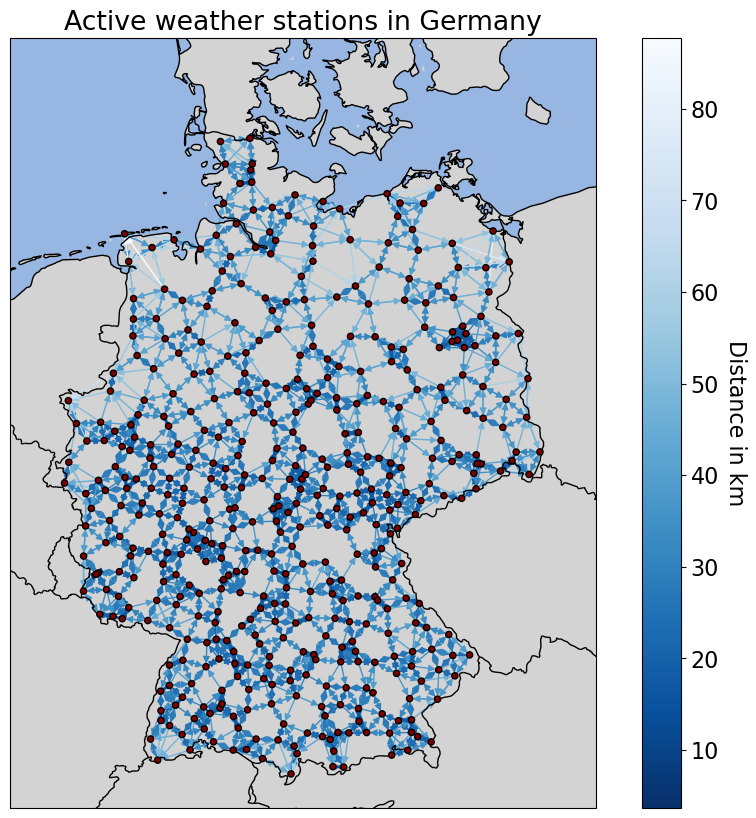

In [17]:
plt.rcParams.update({'font.size': 16})
visualize_graph(torch_data[-1].cpu())

## GNN

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### ⚠️ TODO
 - Attention weights mitteln und anschauen (Kanten in Graph einfärben)
 - Check out GNN explainer

### CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\infty}^{\infty}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution

In [8]:
def crps(mu_sigma: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    :param torch.Tensor mu_sigma: tensor of mean and standard deviation
    :param torch.Tensor y: observed df

    :return tensor: CRPS value
    :rtype torch.Tensor
    """
    mu, sigma = torch.split(mu_sigma, 1, dim=-1)
    y = y.view((-1,1)) # make sure y has the right shape
    pi = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * pi))) * torch.exp(-0.5 * omega ** 2)

    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))

    crps_score = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(pi)))
    return  torch.mean(crps_score)

## GNN
Definition of Model and Training

### Definition of Convolution Layers

In [9]:
class Convolution(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, heads, num_layers:int=None):
        super(Convolution, self).__init__()
        # Make sure either hidden_channels is a list, heads is a list or num_layer is supplied
        assert isinstance(hidden_channels, list) or isinstance(heads, list) or num_layers is not None,\
                "If hidden_channels is not a list, num_layers must be specified."
        # both are a list
        if isinstance(hidden_channels, list) and isinstance(heads, list):
            assert len(hidden_channels) == len(heads), f"Lengths of lists {len(hidden_channels)} and {len(heads)} do not match."
        # only hidden_channels is list
        if isinstance(hidden_channels, list) and not isinstance(heads, list):
            heads = [heads] * len(hidden_channels)
        # only heads is list
        if isinstance(heads, list) and not isinstance(hidden_channels, list):
            hidden_channels = [hidden_channels] * len(heads)
        # none is list
        if not isinstance(heads, list) and not isinstance(hidden_channels, list):
            heads = [heads] * num_layers
            hidden_channels = [hidden_channels] * num_layers
        # definition of Layers
        self.convolutions = ModuleList()
        for c, h in zip(hidden_channels, heads):
            self.convolutions.append(GATv2Conv(in_channels=-1, out_channels=c, heads=h))
        # Last Layer to match shape of output
        self.lin = Linear(in_features=hidden_channels[-1] * heads[-1], out_features=out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = self.lin(x)
        return x


class EmbedStations(torch.nn.Module):
    def __init__(self, num_stations_max, embedding_dim):
        super(EmbedStations, self).__init__()
        self.embed = Embedding(num_embeddings=num_stations_max, embedding_dim=embedding_dim)

    def forward(self, x: torch.Tensor):
        station_ids = x[:, 0].long()
        emb_station = self.embed(station_ids)
        x = torch.cat((emb_station, x[:, 1:]), dim=1) # Concatenate embedded station_id to rest of the feature vector
        return x


class MakePositive(torch.nn.Module):
    def __init__(self):
        super(MakePositive, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu, sigma = torch.split(x, 1, dim=1)
        sigma = F.softplus(sigma)  # ensure that sigma is positive
        mu_sigma = torch.cat([mu, sigma], dim=1)
        return mu_sigma

class UseGlobalContext(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(UseGlobalContext, self).__init__()
        self.aggr = global_mean_pool
        self.lin = Linear(2 * in_features, out_features)

    def forward(self, x:torch.Tensor, batch_id:torch.Tensor) -> torch.Tensor:
        global_features = self.aggr(x, batch_id)
        global_features_per_node = global_features[batch_id]
        input_vec = torch.cat([x, global_features_per_node], dim=-1)
        return self.lin(input_vec)

    
class ResGnn(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int, hidden_channels: int, heads: int):
        super(ResGnn, self).__init__()
        assert num_layers > 0, "num_layers must be > 0."

        # Create Layers
        self.convolutions = ModuleList()
        for _ in range(num_layers):
            self.convolutions.append(GATv2Conv(-1, hidden_channels, heads=heads, edge_dim=1, add_self_loops=True, fill_value=0.01)) #TODO small positive or negative number can be tested
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        x = x.float()
        edge_attr = edge_attr.float()
        for i, conv in enumerate(self.convolutions):
            if i == 0:
                # First Layer
                x = conv(x, edge_index, edge_attr)
                x = F.relu(x)
            else:
                x = x + F.relu(conv(x, edge_index, edge_attr)) # Residual Layers

        x = self.lin(x)
        return x

    @torch.no_grad()
    def get_attention(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Runs a forward Pass for the given graph only though the ResGNN layer.
        NOTE: the data that is given to this method must first pass through the layers before this layer in the Graph

        :param torch.Tensor x: Tensor of Node Features (NxD)
        :param torch.Tensor edge_index: Tensor of Edges (2xE)
        :param torch.Tensor edge_attr: Edge Attributes (ExNum_Attr)
        :return x, edge_index_attention, attention_weights: Tensor of Node Features (NxD), Tensor of Edges with self loops (2xE), Tensor of Attention per edge (ExNum_Heads)
        """
        x = x.float()
        edge_attr = edge_attr.float()

        # Pass Data though Layer to get the Attention
        attention_list = []
        edge_index_attention, attention_weights = None, None  # Note: edge_index_attention has to be added since we have self loops now

        for i, conv in enumerate(self.convolutions,):
            if i == 0:
                # First Layer
                x, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = F.relu(x)
                x = self.norm(x)
            else:
                x_conv, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = x + F.relu(x_conv) # Residual Layers
        x = self.lin(x)

        # TODO Average the attention across all layers
        attention_weights = attention_weights.mean(dim=1)

        return x, edge_index_attention, attention_weights


### Graph Nets Message Passing Layer
The following Layer should be able to compute new node attributes from Messages shared across edges and also compute a global representation which is also used in the node attribute calculation.

$$ \mathbf{h}_i = \phi_{\mathbf{\Theta}} \left( \mathbf{x}_i,
\bigoplus_{j \in \mathcal{N}(i)} \, \psi_{\mathbf{\Theta}}
\left(\mathbf{x}_{i}, \mathbf{x}_{j},\mathbf{e}_{j,i}, \textcolor{green}{x_G}
\right), \textcolor{green}{x_G} \right)$$

$$\textcolor{green}{\mathbf{h}_G = \rho \left(\bigoplus_{i \in \mathcal{V}} \mathbf{h}_i,
\bigoplus_{(i,j) \in \mathcal{E}} \mathbf{h}_{i,j}, \mathbf{x}_G
\right)}$$

We only have to define the functions $\phi_{\mathbf{\Theta}}$ , i.e. update(), and $\psi_{\mathbf{\Theta}}$ , i.e. message(), as well as the aggregation scheme to use, i.e. aggr="add", aggr="mean" or aggr="max".
[Source](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html#implementing-the-gcn-layer)

The $\textcolor{green}{\text{green}}$ symbols are additions to the formulas from PyG, based on this [Lecture](https://www.dropbox.com/s/itsbi113f7ogpbv/AIMS%202022%20-%20Lecture%206%20-%20Graphs%20%26%20Sets%20II.pdf?dl=0).

![](plots/lecture.png)


In [10]:
class MPWGI(MessagePassing):
    """
    Message Passing with Global Information
    """
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels):
        super().__init__(aggr='mean') # use mean aggregation
        self.W1 = Linear(in_channels, out_channels) # used in update
        self.W2 = Linear(hidden_channels, out_channels, bias=False) # used in update
        self.W3 = Linear(global_channels, out_channels, bias=False) # used in update
        self.W4 = Linear(2*in_channels + edge_channels + global_channels, hidden_channels) # used in message
        self.W5 = Linear(hidden_channels + global_channels, global_out_channels) # used for global features
        self.pool = global_mean_pool

    def reset_parameters(self)  -> None:
        """
        Reset all parameters
        :return: None
        """
        self.W1.reset_parameters()
        self.W2.reset_parameters()
        self.W3.reset_parameters()
        self.W4.reset_parameters()
        self.W5.reset_parameters()

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, edge_attr: torch.Tensor, global_features_i: torch.Tensor) -> torch.Tensor:
        """
        Corresponds to psi.
        Constructs a message from node j to node i for each edge in edge_index.
        Tensors passed to propagate() can be mapped to the respective nodes i and j and by appending _i or _j
        :param x_i: features of node i
        :param x_j: features of node j
        :param edge_attr: feature form node i to node j
        :param global_features: global feature of the entire graph (here i is added since multiple graphs can be processed in parallel, then each of the graphs should have their own global attribute)
        :return: message passed from node j to node i
        """
        #global_features = global_features.repeat(x_i.shape[0], 1)
        message_input = torch.cat([x_i, x_j, edge_attr, global_features_i], dim=-1)
        message_transformed = self.W4(message_input)
        #TODO does message_transformed hold all information on messages?
        return message_transformed


    def update(self, inputs: torch.Tensor, x: torch.Tensor, global_features: torch.Tensor) -> torch.Tensor:
        """
        Corresponds to phi.
        Updates node embeddings.
        Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().
        :param inputs: output of aggregation
        :param x: features of node i
        :param global_features: global feature of the entire graph
        :return: updated feature of node i
        """
        update_input = torch.cat([inputs, x, global_features], dim=-1)
        own_hidden_feat = self.W1(x)
        neighbours_hidden_feat = self.W2(inputs)
        global_feat_transformed = self.W3(global_features)
        return own_hidden_feat + neighbours_hidden_feat + global_feat_transformed

    def forward(self, x, edge_index, edge_attr, global_features, batch_id):
        # Every node should have a global feature which is the same for every node in each graph
        # The batch number is stores in batch_id
        global_features_per_node = global_features[batch_id]

        # Propagate Messages
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, global_features=global_features_per_node)

        # Update global feature
        # Corresponds to rho but only takes all nodes into consideration and omits messages
        aggregated_nodes = self.pool(x, batch=batch_id)
        global_input = torch.cat([global_features, aggregated_nodes], dim=-1)
        global_features = self.W5(global_input)

        return x, global_features

class GNNGI(torch.nn.Module):
    """
    Graph Neural Network with global Information
    """
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim):
        """
        Create an instance of a Graph Neural Network with global Information sharing
        :param in_channels: dimension of node attributes before embedding
        :param edge_channels: dimension of edge attributes
        :param global_channels: dimension of global information vector, should be the same as in_channels+edge_channels
        :param hidden_channels: dimension of the message passed along the edges
        :param out_channels: dimension of the new node features
        :param global_out_channels: dimension of the new global feature
        :param num_layers: number of layers
        :param embedding_dim: dimension to use of node embedding
        """
        super(GNNGI, self).__init__()
        self.convolutions = ModuleList()

        assert num_layers > 0, "num_layers must be greater than 0"
        for _ in range(num_layers-1):
            self.convolutions.append(MPWGI(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels))  # in_channels is first the feature size of the nodes
            in_channels = out_channels  # now in_channels is the size of out_channels of the last layer
            global_channels = global_out_channels  # same for global_channels
        self.convolutions.append(MPWGI(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels))  # Last Layer

        self.emb = EmbedStations(num_stations_max=535, embedding_dim=embedding_dim)
        self.pool = global_mean_pool
        self.lin = Linear(out_channels,2)
        self.make_pos = MakePositive()

    def forward(self, x, edge_index, edge_attr, batch_id, global_feature=None):
        x = self.emb(x)  # embed station id

        if global_feature is None:
            global_feature = self.pool(x, batch=batch_id)  # Do batch-wise pooling to create initial global feature

        x, global_feature = self.convolutions[0](x, edge_index, edge_attr, global_feature, batch_id)
        x = F.relu(x)
        global_feature = F.relu(global_feature)

        if len(self.convolutions) > 1:
            for conv in self.convolutions[1:]:
                x_new, global_features_new = conv(x, edge_index, edge_attr, global_feature, batch_id)
                x = x + F.relu(x_new)  # Resnet
                global_feature = global_feature + F.relu(global_features_new)  #Resnet

        x = self.lin(x)

        mu_sigma = self.make_pos(x)
        return mu_sigma

### Construction of Network

In [11]:
# TODO another parameter
LR = 0.001
embed_dim = 2
hidden_channels = 256
heads = 2
num_layers = 1

# Initialize the model and optimizer
num_features = torch_data[0].num_features
emb_num_features = num_features + embed_dim -1

def create_model(embed_dim: int, in_channels: int, hidden_channels: int,  num_layers:int, compile: bool=False)-> torch.nn.Module:
    """
    Create a graph neural network model for node level regression.

    :param embed_dim: The dimensionality of the node embeddings.
    :param in_channels: The number of input features for the node embeddings.
    :param hidden_channels: The number of hidden channels in the Convolution layers.
    :param num_layers: The number Convolution layers in the model.
    :param compile: Whether to compile the model with torch_geometric. Defaults to False
    :return: Model
    :rtype: torch.nn.Module
    """
    # Clear Cache
    torch.cuda.empty_cache()
    mod = Sequential('x, edge_index, edge_attr, batch_id',
                       [
                           (EmbedStations(num_stations_max=535, embedding_dim=embed_dim ), 'x -> x'),

                           (ResGnn(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),

                           #(GraphSAGE(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, out_channels=2, project=True, aggr='mean'), 'x, edge_index -> x'),

                           #(MLP(in_channels=emb_num_features, out_channels=2, hidden_channels=512, num_layers=2),'x -> x'),

                           (MakePositive(), 'x -> mu_sigma')
                      ])
    # mod = GNNGI(in_channels=in_channels,
    #                edge_channels=1,
    #                global_channels=in_channels,
    #                hidden_channels=hidden_channels,
    #                out_channels=hidden_channels,
    #                global_out_channels=in_channels,
    #                num_layers=num_layers,
    #                embedding_dim=embed_dim)

    mod.to(device)
    # Compile the model
    if compile: torch_geometric.compile(mod)
    return  mod

### Ensemble Training
An ensemble of ```n_reps``` models is trained for 80 periods or until the validation loss has not decreased in 30 epochs per model.

In [20]:
# Class for an ensemble of models
class Ensemble(torch.nn.Module):
    def __init__(self, n_reps, lr, *args, **kwargs):
        super(Ensemble, self).__init__()
        self.models = torch.nn.ModuleList([create_model(*args, **kwargs) for _ in range(n_reps)])
        self.optimizers = [torch.optim.AdamW(model.parameters(), lr=lr) for model in self.models]

    def forward(self, *args, **kwargs):
        predictions = [model(*args, **kwargs) for model in self.models]
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
        return avg_predictions


### Ususal Trainaing

In [12]:
log_WandB = False

In [14]:
#TODO more hyperparams here
n_epochs = 182
patience = 182  # TODO also try with much lower learning rate
n_reps = 1

LR=LR
schedule_lr=False


if log_WandB:
    wandb.init(
    # set the wandb project where this run will be logged
        project="GNNPP",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": LR,
        "architecture": "ResNetv2",
        "embed_dim": embed_dim,
        "num_layers": num_layers,
        "hidden_channels": hidden_channels,
        "heads": heads,
        "max_epochs": n_epochs,
        "patience": patience,
        "batch_size": BS,
        "max_dist": max_dist
        }
    )


def train(batch):
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
    loss = crps(out, batch.y)
    loss.backward()
    optimizer.step()
    #scheduler.step() #TODO change back
    return loss

@torch.no_grad()
def valid(batch):
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
    loss = crps(out, batch.y)
    return loss

model_list = []
train_losses_models = []
validation_losses_models = []

for i in range(n_reps):
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    no_improvement = 0

    # loading bar
    epochs_pbar = trange(n_epochs, desc="Epochs")

    model = create_model(embed_dim=embed_dim,
                         in_channels=emb_num_features,
                         hidden_channels=hidden_channels,
                         num_layers=num_layers,
                         compile=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #momentum anschauen

    # Learning Rate Scheduler
    scheduler = None
    if schedule_lr:
        sched = ExponentialLR(optimizer, gamma=0.99)

    for epoch in epochs_pbar:
        # Train for one epoch
        model.train()
        train_loss = 0.0

        for batch in train_loader_small: #TODO
            loss = train(batch)
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader_small.dataset)  #TODO
        train_losses.append(train_loss)

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0

        for batch in train_loader_small: # TODO
            loss = valid(batch)
            val_loss += loss.item() * batch.num_graphs
        val_loss /= len(train_loader_small.dataset) # TODO
        validation_losses.append(val_loss)

        # Log to WandB
        if log_WandB:
            wandb.log({"train_loss": train_loss, "val_loss": val_loss})

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            # Save model checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"checkpoints/checkpoint_model_{i}.pt")
        else:
            no_improvement += 1

        epochs_pbar.set_postfix({"Train Loss": train_loss,
                                 "Val Loss": val_loss,
                                 "Best Loss": best_val_loss,
                                 "No Improvement": no_improvement})

        # Early stopping
        if no_improvement == patience:
            print('Early stopping.')
            break

    if log_WandB:
        wandb.log({"best_val_loss": best_val_loss, "trained_epochs":  epoch-patience})

    # Load weights from model checkpoint
    checkpoint = torch.load(f"checkpoints/checkpoint_model_{i}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Set model to eval mode
    model.eval()
    model_list.append(model)
    train_losses_models.append(train_losses)
    validation_losses_models.append(validation_losses)

Epochs: 100%|██████████| 182/182 [01:49<00:00,  1.66it/s, Train Loss=0.818, Val Loss=0.828, Best Loss=0.782, No Improvement=6] 


In [46]:
# Load model from memory
# Only needed if there is a crash but some models are already trained
if False:
    model_list = []
    for snapshot in os.listdir("checkpoints"):
        model = Ensemble(n_reps,
                     embed_dim=embed_dim,
                     in_channels=emb_num_features,
                     hidden_channels=hidden_channels,
                     num_layers=num_layers)
        try:
            checkpoint = torch.load(f"checkpoints/{snapshot}")
            model.load_state_dict(checkpoint['model_state_dict'])
            model_list.append(model)
        except:
            print(f"could not load {snapshot}, model architectures do not match")

NameError: name 'Ensemble' is not defined

In [42]:
# Summary of model
tmp = torch_data[1000]

print(summary(model_list[0],
              x=tmp.x.to(device),
              edge_index=tmp.edge_index.to(device),
              edge_attr=tmp.edge_attr.to(device),
              batch_id=torch.zeros(tmp.x.shape[0]).to(torch.int64).to(device)))

IndexError: list index out of range

Text(0, 0.5, 'Loss')

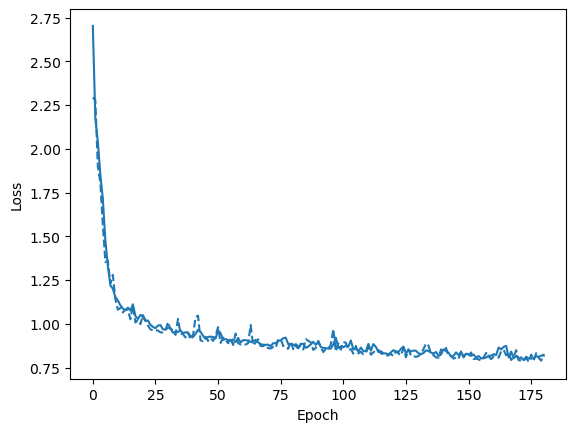

In [15]:
cmap = mpl.colormaps['tab10']
for i, (t, v) in enumerate(zip(train_losses_models, validation_losses_models)):
    plt.plot(t[1:], linestyle='solid', color=cmap(i))
    plt.plot(v[1:], linestyle='dashed',  color=cmap(i))
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Evaluation
Calculation of CRPS on test set and graphical diagnostics

In [19]:
torch_data_test = [tensor.to(device) for tensor in torch_data[-366:]]
test_loader = DataLoader(torch_data_test, batch_size=BS, shuffle=False)

In [20]:
mu_list_model = []
sigma_list_model = []

for model in model_list:
    mu_list_batch = []
    sigma_list_batch = []
    y_list = []

    for batch in test_loader:
        batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        mu, sigma = torch.split(out, 1, dim=-1)
        y = batch.y
        y = y.cpu().numpy()
        y_list.append(y)

        mu = mu.detach().cpu().numpy().flatten()
        mu_list_batch.append(mu)
        sigma = sigma.detach().cpu().numpy().flatten()
        sigma_list_batch.append(sigma)


    mu = np.concatenate(mu_list_batch)
    mu_list_model.append(mu)
    sigma = np.concatenate(sigma_list_batch)
    sigma_list_model.append(sigma)
    y = np.concatenate(y_list)
mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

mu = torch.tensor(mu).to(device)
sigma = torch.tensor(sigma).to(device)
preds = torch.cat([mu, sigma], dim=1)
y = torch.tensor(y).to(device)
err = crps(mu_sigma=preds, y=y)

y = y.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
sigma = sigma.detach().cpu().numpy()
err

tensor(0.8761, device='cuda:0')

Text(0.5, 1.0, 'Predicted vs. observed 2m-temperatures\nCRPS=0.8761')

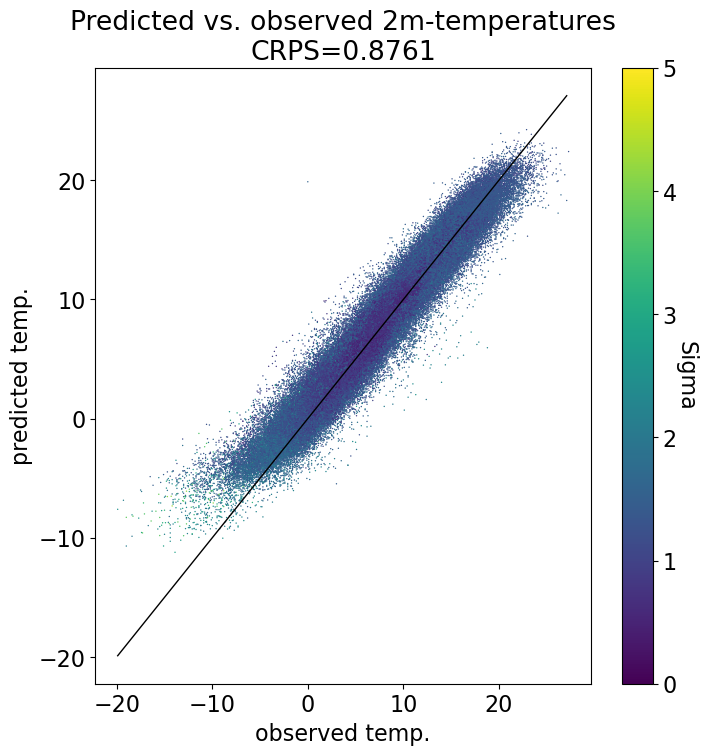

In [21]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=5)

cbar = plt.colorbar()
cbar.set_label('Sigma', rotation=270, labelpad=15)
plt.xlabel('observed temp.')
plt.ylabel('predicted temp.')
plt.title(f"Predicted vs. observed 2m-temperatures\nCRPS={err:.4f}")

In [ ]:
if log_WandB:
    # save code
    wandb.save("gnn.ipynb")
    wandb.save("helpers.py")
    # finish logging
    wandb.finish()

## Explainability

In [88]:
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import GNNExplainer, PGExplainer

In [89]:
from torch_geometric.explain.config import ModelMode

class GNNCRPSExplainer(GNNExplainer):
    def _loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if self.model_config.mode == ModelMode.binary_classification:
            loss = self._loss_binary_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.multiclass_classification:
            loss = self._loss_multiclass_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.regression:
            loss = crps(y_hat, y)  # Changed this Line only
        else:
            assert False

        if self.hard_edge_mask is not None:
            assert self.edge_mask is not None
            m = self.edge_mask[self.hard_edge_mask].sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + self.coeffs['EPS']) - (
                1 - m) * torch.log(1 - m + self.coeffs['EPS'])
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        if self.hard_node_mask is not None:
            assert self.node_mask is not None
            m = self.node_mask[self.hard_node_mask].sigmoid()
            node_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
            loss = loss + self.coeffs['node_feat_size'] * node_reduce(m)
            ent = -m * torch.log(m + self.coeffs['EPS']) - (
                1 - m) * torch.log(1 - m + self.coeffs['EPS'])
            loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

class PGCRPSExplainer(PGExplainer):
    def _loss(self, y_hat: torch.Tensor, y: torch.Tensor, edge_mask: torch.Tensor) -> torch.Tensor:
        if self.model_config.mode == ModelMode.binary_classification:
            loss = self._loss_binary_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.multiclass_classification:
            loss = self._loss_multiclass_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.regression:
            loss = crps(y_hat, y)

        # Regularization loss:
        mask = edge_mask.sigmoid()
        size_loss = mask.sum() * self.coeffs['edge_size']
        mask = 0.99 * mask + 0.005
        mask_ent = -mask * mask.log() - (1 - mask) * (1 - mask).log()
        mask_ent_loss = mask_ent.mean() * self.coeffs['edge_ent']

        return loss + size_loss + mask_ent_loss

In [90]:
nodes_with_emb = model_list[0][0](tmp.x.to(device)).detach()
model_gnn_part = Sequential('x, edge_index, edge_attr, batch_id',
                            [(model_list[0][1],'x, edge_index -> x'),
                            (model_list[0][2],'x  -> mu_sigma')])

In [91]:
tmp = torch_data[-1]
node_index = [i for i in range(1)]  # All Nodes -1 because there is node 0

explainer = Explainer(model=model_list[0],
                algorithm=GNNCRPSExplainer(),
                explanation_type='phenomenon',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=ModelConfig(
                    mode='regression',
                    task_level='node',
                    return_type='raw')
                )

In [92]:
# Only for pg explainer
for epoch in trange(30):
    for index in range(10):  # Indices to train against.
        loss = explainer.algorithm.train(epoch=epoch,
                                         model=model.cpu(),
                                         x=tmp.x.cpu(),
                                         edge_index=tmp.edge_index.cpu(),
                                         edge_attr = tmp.edge_attr.cpu(),
                                         batch_id = torch.zeros(tmp.x.shape[0], dtype=torch.int64),
                                         target=tmp.y.cpu(),
                                         index=index)

  0%|          | 0/30 [00:00<?, ?it/s]


TypeError: Module.train() got an unexpected keyword argument 'epoch'

In [93]:
explanation = explainer(tmp.x.to(device),
                        tmp.edge_index.to(device),
                        edge_attr=tmp.edge_attr.to(device),
                        batch_id=torch.zeros(tmp.x.shape[0], dtype=torch.int64 ,device=device),
                        index=node_index,
                        target = tmp.y.to(device))

exp_subgraph = explanation.get_explanation_subgraph()

ValueError: Explainability of message passing modules is only supported on the Python module

In [94]:
feat_labels = data.columns.drop(['obs', 'date']).tolist()
#feat_labels = [f"emb_dim{dim}" for dim in range(embed_dim)] + feat_labels
explanation.visualize_feature_importance(feat_labels=feat_labels)

NameError: name 'explanation' is not defined

In [95]:
visualize_explanation(exp_subgraph.cpu(), tmp.cpu(), stations=stations)

NameError: name 'exp_subgraph' is not defined

### Explainer Test
05.07.2023

In [96]:
node_index = 10

x=tmp.x.to(device)
edge_index=tmp.edge_index.to(device)
edge_attr = tmp.edge_attr.to(device)
batch_id = torch.zeros(tmp.x.shape[0], dtype=torch.int64).to(device)

explainer = GNNExplainer(model)

### Permutation based explanation methods (see Slerch Paper)